In [ ]:
import torch

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [ ]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Hyperparameters
batch_size = 32
seq_len = 30      # n days long of 1 sequence

d_k = 256         # Dimension of query and key in attention layer
d_v = 256         # Dimension of value in attention layer
n_heads = 12      # Number of single-attention layer
ff_dim = 256      # 

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
data_file = '/content/drive/My Drive/SC201_May_H/data_set(0616).csv'

df = pd.read_csv(data_file, index_col=0)

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('date', inplace=True)

# df.pop('Institution_Total')
# df.pop('Short Sale/Margin Purchase Ratio')
# df.pop('MA5')
# df.pop('MA10')
# df.pop('MA20')
# df.pop('MA60')
# df.pop('RSI')

df.tail()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5oXB5bxZP9ppr5gmQ7JZDS1Z9julLLeoQSvvN67aa2plOxHEaO91E
Mounted at /content/drive


,date,Institution_Total,Short Sale/Margin Purchase Ratio,Open,High,Low,Close,Volume,MA5,MA10,MA20,MA60,RSI
20210609,20210609,-16342775813,0.063201,17082.519531,17082.519531,16907.429688,16966.220703,6310000.0,17103.982422,17038.823047,16572.000977,16716.424087,54.268230
20210610,20210610,18163729607,0.061311,17024.539063,17159.220703,16978.009766,17159.220703,6582700.0,17086.594531,17094.584180,16646.457031,16731.588930,58.408906
20210611,20210611,9980190405,0.059396,17200.449219,17278.550781,17193.609375,17213.519531,6154800.0,17099.816406,17128.850195,16715.778516,16746.594920,59.519405
20210615,20210615,14553407318,0.060826,17279.700000,17371.290000,17279.700000,17371.290000,6317500.0,17157.292375,17159.136226,16816.648533,16765.852748,62.640709
20210616,20210616,-17236327449,0.058233,17357.370000,17398.220000,17275.020000,17307.860000,7962000.0,17203.622187,17173.684141,16874.742510,16782.853084,60.617048


In [ ]:
'''Create indexes to split dataset'''

times = sorted(df.index.values)

# Define start of test data
import random
random.seed(0)
start = random.randint(0, len(times))
end = start + int(0.06*len(times))

test_start = sorted(df.index.values)[start]
test_end = sorted(df.index.values)[end]

###############################################################################
'''Normalize price columns'''

# min_price = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
# max_price = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

min_price = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_price = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_price) / (max_price - min_price)
df['High'] = (df['High'] - min_price) / (max_price - min_price)
df['Low'] = (df['Low'] - min_price) / (max_price - min_price)
df['Close'] = (df['Close'] - min_price) / (max_price - min_price)

###############################################################################
'''Normalize volume column'''

# min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
# max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

min_volume = df['Volume'].min(axis=0)
max_volume = df['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Normalize Institution_Total column'''

# min_value = df[(df.index < last_20pct)]['Institution_Total'].min(axis=0)
# max_value = df[(df.index < last_20pct)]['Institution_Total'].max(axis=0)

min_value = df['Institution_Total'].min(axis=0)
max_value = df['Institution_Total'].max(axis=0)

# Min-max normalize Institution_Total columns (0-1 range)
df['Institution_Total'] = (df['Institution_Total'] - min_value) / (max_value - min_value)

###############################################################################
'''Normalize Short Sale/Margin Purchase Ratio column'''

# min_ratio = df[(df.index < last_20pct)]['Short Sale/Margin Purchase Ratio'].min(axis=0)
# max_ratio = df[(df.index < last_20pct)]['Short Sale/Margin Purchase Ratio'].max(axis=0)

min_ratio = df['Short Sale/Margin Purchase Ratio'].min(axis=0)
max_ratio = df['Short Sale/Margin Purchase Ratio'].max(axis=0)

# Min-max normalize Short Sale/Margin Purchase Ratio columns (0-1 range)
df['Short Sale/Margin Purchase Ratio'] = (df['Short Sale/Margin Purchase Ratio'] - min_ratio) / (max_ratio - min_ratio)

###############################################################################
'''Normalize MA columns'''

# min_ma = min(df[(df.index < last_20pct)][['MA5', 'MA10', 'MA20', 'MA60']].min(axis=0))
# max_ma = max(df[(df.index < last_20pct)][['MA5', 'MA10', 'MA20', 'MA60']].max(axis=0))

min_ma = min(df[['MA5', 'MA10', 'MA20', 'MA60']].min(axis=0))
max_ma = max(df[['MA5', 'MA10', 'MA20', 'MA60']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['MA5'] = (df['MA5'] - min_ma) / (max_ma - min_ma)
df['MA10'] = (df['MA10'] - min_ma) / (max_ma - min_ma)
df['MA20'] = (df['MA20'] - min_ma) / (max_ma - min_ma)
df['MA60'] = (df['MA60'] - min_ma) / (max_ma - min_ma)

###############################################################################
'''Normalize RSI column'''

# min_rsi = df[(df.index < last_20pct)]['RSI'].min(axis=0)
# max_rsi = df[(df.index < last_20pct)]['RSI'].max(axis=0)

min_rsi = df['RSI'].min(axis=0)
max_rsi = df['RSI'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['RSI'] = (df['RSI'] - min_rsi) / (max_rsi - min_rsi)

###############################################################################

# Remove date column
df.drop(columns=['date'], inplace=True)

# Filter out test data (random 5%)
df_train_val = pd.concat([df[(df.index < test_start)], df[(df.index > test_end)]])
df_test = df[(df.index >= test_start) & (df.index <= test_end)]

# Convert pandas columns into arrays
d = df.values
data = df_train_val.values
test_data = df_test.values

print(df_train_val)
print(df_test)

          Institution_Total  ...       RSI
20110103           0.757107  ...  0.891789
20110104           0.713575  ...  0.841901
20110105           0.666483  ...  0.627755
20110106           0.669022  ...  0.659695
20110107           0.677651  ...  0.550084
...                     ...  ...       ...
20210609           0.576864  ...  0.596646
20210610           0.812546  ...  0.652389
20210611           0.756652  ...  0.667339
20210615           0.787887  ...  0.709358
20210616           0.570761  ...  0.682115

[2411 rows x 12 columns]
          Institution_Total  ...       RSI
20170605           0.721199  ...  0.826571
20170606           0.684397  ...  0.788554
20170607           0.701252  ...  0.791859
20170608           0.703440  ...  0.806002
20170609           0.660277  ...  0.752842
...                     ...  ...       ...
20180103           0.742523  ...  0.738473
20180104           0.737461  ...  0.766576
20180105           0.721141  ...  0.784667
20180108           0.728994 

In [ ]:
pred_days = 5

'''Shuffle data without test data'''
X, y = [], []
for i in range(seq_len, len(data)):
  if i+pred_days < len(data):
    X.append(data[i-seq_len:i])
    y.append(data[:, 3][i+pred_days])
random.seed(0)
random.shuffle(X)
random.seed(0)
random.shuffle(y)

'''Split data into train, validation and test sets'''

num_inputs = len(X)
p_train = 90 / 95

# Training data
X_train = X[:int(num_inputs*p_train)]
y_train = y[:int(num_inputs*p_train)]
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation data
X_val = X[int(num_inputs*p_train):]
y_val = y[int(num_inputs*p_train):]
X_val, y_val = np.array(X_val), np.array(y_val)

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
  if i+pred_days < len(test_data):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i+pred_days])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (2250, 30, 12) (2250,)
Validation set shape (126, 30, 12) (126,)
Testing set shape (119, 30, 12) (119,)


In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [ ]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
                                # num_features
  in_seq = Input(shape=(seq_len, 12))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.2)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model

model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 12)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 30, 2)        120         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 30, 14)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 30, 14)       188756      concatenate[0][0]            

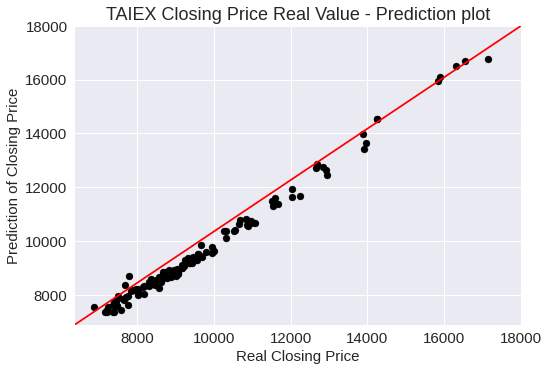

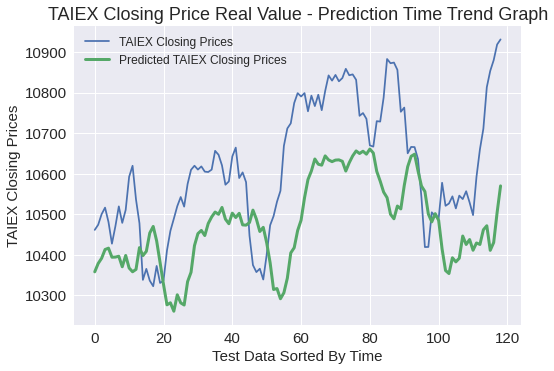

In [14]:
'''Display results'''
import matplotlib.lines as mlines

y_val_b4_normalize = []
val_pred_b4_normalize = []

# Un-normalize data
for ele in y_val:
  ele_b4_normalize = ele*(max_price - min_price)+min_price
  y_val_b4_normalize.append(ele_b4_normalize)

for ele in val_pred:
  ele_b4_normalize = ele*(max_price - min_price)+min_price
  val_pred_b4_normalize.append(ele_b4_normalize)

fig, ax = plt.subplots()
ax.scatter(y_val_b4_normalize, val_pred_b4_normalize, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xticks([8000,10000,12000,14000,16000,18000])
ax.set_yticks([8000,10000,12000,14000,16000,18000])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_title('TAIEX Closing Price Real Value - Prediction plot', fontsize=18)
ax.set_xlabel('Real Closing Price', fontsize=15)
ax.set_ylabel('Prediction of Closing Price', fontsize=15)
plt.show()

#Plot test data results
y_test_b4_normalize = []
test_pred_b4_normalize = []

for ele in y_test:
  ele_b4_normalize = ele*(max_price - min_price)+min_price
  y_test_b4_normalize.append(ele_b4_normalize)

for ele in test_pred:
  ele_b4_normalize = ele*(max_price - min_price)+min_price
  test_pred_b4_normalize.append(ele_b4_normalize)

# 閔昭的圖的title, label如下
# plt.title('TAIEX Closing Price Real Value - Prediction Time Trend Graph', fontsize=18)
# plt.xlabel('Test Data Sorted By Time', fontsize=15)
# plt.ylabel('TAIEX Closing Price', fontsize=15)

# 如果想要讓兩張圖一樣大小，就打開下方code
fig_, ax_ = plt.subplots()
ax_.plot(y_test_b4_normalize, label='TAIEX Closing Prices')
ax_.plot(np.arange(0, test_pred.shape[0]), test_pred_b4_normalize, linewidth=3, label='Predicted TAIEX Closing Prices')
ax_.set_title('TAIEX Closing Price Real Value - Prediction Time Trend Graph', fontsize=18)
ax_.set_xlabel('Test Data Sorted By Time',fontsize=15)
ax_.set_ylabel('TAIEX Closing Prices',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax_.legend(loc="best", fontsize=12)
plt.show()